In [267]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import signal

In [281]:
experiments = [
    '0.25 bar',
    '0.25 bar 2',
    '0.5 bar',
    '0.5 bar 2',
    '0.5 bar 3',
    '0.75 bar',
    '0.75 bar 2',
    '1 bar',
    '1 bar 2',
    '1.25 bar',
    '1.25 bar 2',
    '1.5 bar',
    '1.5 bar 2',
    '1.5 bar 3'
]


In [282]:
pressures = np.array([
    0.25,
    0.25,
    0.5,
    0.5,
    0.5,
    0.75,
    0.75,
    1,
    1,
    1.25,
    1.25,
    1.5,
    1.5,
    1.5
])
detected = np.array([])

In [285]:
pressures = np.append(pressures, 1.5)


In [375]:

i = 5
files = glob.glob("Day 2/"+experiments[i]+"/*.txt")
data = np.loadtxt(files[0], skiprows=3)
for f in files[1:]:
    buff = np.loadtxt(f, skiprows=3)
    buff[:,0] += data[-1,0]
    data = np.append(data, buff, axis=0)
data[:,1] -= np.min(data[:,1])
data[:,1] /= np.max(data[:,1])

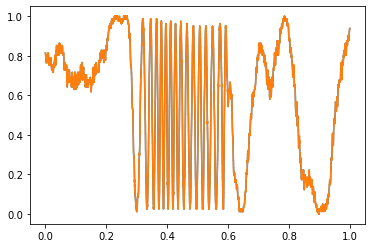

In [376]:
intervals = [
    [8100, 19700],
    [10700, 16900],
    [20200, 33500],
    [15200, 22300],
    [12700, 19300],
    [0, -1],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    []
]
start = intervals[i][0]
end = intervals[i][1]
plt.plot(data[:,0], data[:,1])
plt.plot(data[start:end,0], data[start:end,1])

In [257]:
def adv_sine(x, *args):
    a,b,c,d,e,f = args
    return np.sin(c+d*x+e*x*x+f*x*x*x)*(a) + b
start = 21000
end = 51000
popt, pcov = curve_fit(adv_sine, data[start:end,0], data[start:end,1], p0=[1, 0.5, 0, 100, 20, -10], maxfev=3000)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 3000.

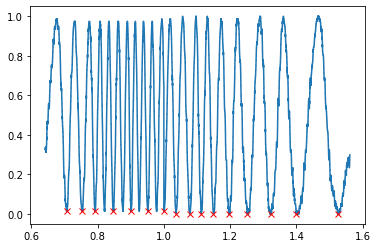

In [262]:
# xs = np.linspace(data[start,0], data[end,0], 10000)
# plt.plot(xs, adv_sine(xs, *popt))
plt.plot(data[start:end,0], data[start:end,1])
zeros = find_peaks(-data[start:end,1], height=-0.2, distance=1000)[0]
plt.plot(data[zeros+start,0], data[zeros+start,1], 'rx')

In [263]:
len(zeros)*2*np.pi

100.53096491487338

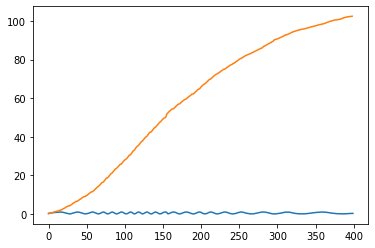

In [277]:
resmpl = signal.resample(data[start:end,1], 400)
resmpl -= np.min(resmpl)
resmpl /= np.max(resmpl)
plt.plot(resmpl)
plt.plot(np.cumsum(np.abs(np.diff(np.arccos(2*resmpl-1)))))

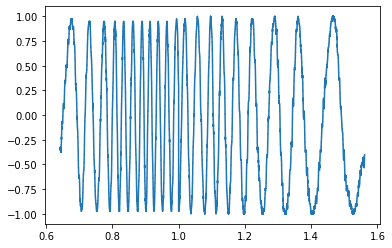

In [230]:
start = 21000
end = 51000
plt.plot(data[start:end,0], 2*data[start:end,1]-1)

In [278]:
np.cumsum(np.abs(np.diff(np.arccos(2*resmpl-1))))[-1]

102.46412269382797